In [1]:
from helper_functions import *
from hamiltonians import *
from classical_solution import *

from tqdm.auto import tqdm

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

/Users/farrokhlabib/Documents/github/QLASS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hamiltonians to minimize (from Perceval VQE tutorial)

In [2]:
Hamiltonian_elem = np.array([[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],    #00
                             [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],    #II
                             [[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]],    #IX
                             [[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]],  #IZ
                             [[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]],    #XI
                             [[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]],    #XX
                             [[0,0,1,0],[0,0,0,-1],[1,0,0,0],[0,-1,0,0]],  #XZ
                             [[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]],  #ZI
                             [[0,1,0,0],[1,0,0,0],[0,0,0,-1],[0,0,-1,0]],  #ZX
                             [[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]]) #ZZ


Hamiltonian_coef = np.matrix(
# [R, II, IX, IZ, XI, XX, XZ, ZI, ZX, ZZ]
[[0.05,33.9557,-0.1515,-2.4784,-0.1515,0.1412,0.1515,-2.4784,0.1515,0.2746],
[0.1,13.3605,-0.1626,-2.4368,-0.1626,0.2097,0.1626,-2.4368,0.1626,0.2081],
[0.15,6.8232,-0.1537,-2.3801,-0.1537,0.2680,0.1537,-2.3801,0.1537,0.1512],
[0.2,3.6330,-0.1405,-2.2899,-0.1405,0.3027,0.1405,-2.2899,0.1405,0.1176],
[0.25,1.7012,-0.1324,-2.1683,-0.1324,0.3211,0.1324,-2.1683,0.1324,0.1010],
[0.3,0.3821,-0.1306,-2.0305,-0.1306,0.3303,0.1306,-2.0305,0.1306,0.0943],
[0.35,-0.5810,-0.1335,-1.8905,-0.1335,0.3344,0.1335,-1.8905,0.1335,0.0936],
[0.4,-1.3119,-0.1396,-1.7568,-0.1396,0.3352,0.1396,-1.7568,0.1396,0.0969],
[0.45,-1.8796,-0.1477,-1.6339,-0.1477,0.3339,0.1477,-1.6339,0.1477,0.1030],
[0.5,-2.3275,-0.1570,-1.5236,-0.1570,0.3309,0.1570,-1.5236,0.1570,0.1115],
[0.55,-2.6844,-0.1669,-1.4264,-0.1669,0.3264,0.1669,-1.4264,0.1669,0.1218],
[0.6,-2.9708,-0.1770,-1.3418,-0.1770,0.3206,0.1770,-1.3418,0.1770,0.1339],
[0.65,-3.2020,-0.1871,-1.2691,-0.1871,0.3135,0.1871,-1.2691,0.1871,0.1475],
[0.7,-3.3893,-0.1968,-1.2073,-0.1968,0.3052,0.1968,-1.2073,0.1968,0.1626],
[0.75,-3.5417,-0.2060,-1.1552,-0.2060,0.2958,0.2060,-1.1552,0.2060,0.1791],
[0.8,-3.6660,-0.2145,-1.1117,-0.2145,0.2853,0.2145,-1.1117,0.2145,0.1968],
[0.85,-3.7675,-0.2222,-1.0758,-0.2222,0.2738,0.2222,-1.0758,0.2222,0.2157],
[0.9,-3.8505,-0.2288,-1.0466,-0.2288,0.2613,0.2288,-1.0466,0.2288,0.2356],
[0.95,-3.9183,-0.2343,-1.0233,-0.2343,0.2481,0.2343,-1.0233,0.2343,0.2564],
[1,-3.9734,-0.2385,-1.0052,-0.2385,0.2343,0.2385,-1.0052,0.2385,0.2779],
[1.05,-4.0180,-0.2414,-0.9916,-0.2414,0.2199,0.2414,-0.9916,0.2414,0.3000],
[1.1,-4.0539,-0.2430,-0.9820,-0.2430,0.2053,0.2430,-0.9820,0.2430,0.3225],
[1.15,-4.0825,-0.2431,-0.9758,-0.2431,0.1904,0.2431,-0.9758,0.2431,0.3451],
[1.2,-4.1050,-0.2418,-0.9725,-0.2418,0.1756,0.2418,-0.9725,0.2418,0.3678],
[1.25,-4.1224,-0.2392,-0.9716,-0.2392,0.1610,0.2392,-0.9716,0.2392,0.3902],
[1.3,-4.1356,-0.2353,-0.9728,-0.2353,0.1466,0.2353,-0.9728,0.2353,0.4123],
[1.35,-4.1454,-0.2301,-0.9757,-0.2301,0.1327,0.2301,-0.9757,0.2301,0.4339],
[1.4,-4.1523,-0.2239,-0.9798,-0.2239,0.1194,0.2239,-0.9798,0.2239,0.4549],
[1.45,-4.1568,-0.2167,-0.9850,-0.2167,0.1068,0.2167,-0.9850,0.2167,0.4751],
[1.5,-4.1594,-0.2086,-0.9910,-0.2086,0.0948,0.2086,-0.9910,0.2086,0.4945],
[1.55,-4.1605,-0.1998,-0.9975,-0.1998,0.0837,0.1998,-0.9975,0.1998,0.5129],
[1.6,-4.1602,-0.1905,-1.0045,-0.1905,0.0734,0.1905,-1.0045,0.1905,0.5304],
[1.65,-4.1589,-0.1807,-1.0116,-0.1807,0.0640,0.1807,-1.0116,0.1807,0.5468],
[1.7,-4.1568,-0.1707,-1.0189,-0.1707,0.0555,0.1707,-1.0189,0.1707,0.5622],
[1.75,-4.1540,-0.1605,-1.0262,-0.1605,0.0479,0.1605,-1.0262,0.1605,0.5766],
[1.8,-4.1508,-0.1503,-1.0334,-0.1503,0.0410,0.1503,-1.0334,0.1503,0.5899],
[1.85,-4.1471,-0.1403,-1.0404,-0.1403,0.0350,0.1403,-1.0404,0.1403,0.6023],
[1.9,-4.1431,-0.1305,-1.0473,-0.1305,0.0297,0.1305,-1.0473,0.1305,0.6138],
[1.95,-4.1390,-0.1210,-1.0540,-0.1210,0.0251,0.1210,-1.0540,0.1210,0.6244],
[2,-4.1347,-0.1119,-1.0605,-0.1119,0.0212,0.1119,-1.0605,0.1119,0.6342],
[2.05,-4.1303,-0.1031,-1.0667,-0.1031,0.0178,0.1031,-1.0667,0.1031,0.6432],
[2.1,-4.1258,-0.0949,-1.0727,-0.0949,0.0148,0.0949,-1.0727,0.0949,0.6516],
[2.15,-4.1214,-0.0871,-1.0785,-0.0871,0.0124,0.0871,-1.0785,0.0871,0.6594],
[2.2,-4.1169,-0.0797,-1.0840,-0.0797,0.0103,0.0797,-1.0840,0.0797,0.6666],
[2.25,-4.1125,-0.0729,-1.0893,-0.0729,0.0085,0.0729,-1.0893,0.0729,0.6733],
[2.3,-4.1082,-0.0665,-1.0944,-0.0665,0.0070,0.0665,-1.0944,0.0665,0.6796],
[2.35,-4.1040,-0.0606,-1.0993,-0.0606,0.0058,0.0606,-1.0993,0.0606,0.6854],
[2.4,-4.0998,-0.0551,-1.1040,-0.0551,0.0047,0.0551,-1.1040,0.0551,0.6909],
[2.45,-4.0957,-0.0500,-1.1085,-0.0500,0.0039,0.0500,-1.1085,0.0500,0.6961],
[2.5,-4.0918,-0.0454,-1.1128,-0.0454,0.0032,0.0454,-1.1128,0.0454,0.7010],
[2.55,-4.0879,-0.0411,-1.1170,-0.0411,0.0026,0.0411,-1.1170,0.0411,0.7056],
[2.6,-4.0841,-0.0371,-1.1210,-0.0371,0.0021,0.0371,-1.1210,0.0371,0.7099],
[2.65,-4.0805,-0.0335,-1.1248,-0.0335,0.0017,0.0335,-1.1248,0.0335,0.7141],
[2.7,-4.0769,-0.0303,-1.1285,-0.0303,0.0014,0.0303,-1.1285,0.0303,0.7181],
[2.75,-4.0735,-0.0273,-1.1321,-0.0273,0.0011,0.0273,-1.1321,0.0273,0.7218],
[2.8,-4.0701,-0.0245,-1.1356,-0.0245,0.0009,0.0245,-1.1356,0.0245,0.7254],
[2.85,-4.0669,-0.0221,-1.1389,-0.0221,0.0007,0.0221,-1.1389,0.0221,0.7289],
[2.9,-4.0638,-0.0198,-1.1421,-0.0198,0.0006,0.0198,-1.1421,0.0198,0.7322],
[2.95,-4.0607,-0.0178,-1.1452,-0.0178,0.0005,0.0178,-1.1452,0.0178,0.7354],
[3,-4.0578,-0.0159,-1.1482,-0.0159,0.0004,0.0159,-1.1482,0.0159,0.7385],
[3.05,-4.0549,-0.0142,-1.1511,-0.0142,0.0003,0.0142,-1.1511,0.0142,0.7414],
[3.1,-4.0521,-0.0127,-1.1539,-0.0127,0.0002,0.0127,-1.1539,0.0127,0.7443],
[3.15,-4.0494,-0.0114,-1.1566,-0.0114,0.0002,0.0114,-1.1566,0.0114,0.7470],
[3.2,-4.0468,-0.0101,-1.1592,-0.0101,0.0001,0.0101,-1.1592,0.0101,0.7497],
[3.25,-4.0443,-0.0090,-1.1618,-0.0090,0.0001,0.0090,-1.1618,0.0090,0.7522],
[3.3,-4.0418,-0.0081,-1.1643,-0.0081,0.0001,0.0081,-1.1643,0.0081,0.7547],
[3.35,-4.0394,-0.0072,-1.1666,-0.0072,0.0001,0.0072,-1.1666,0.0072,0.7571],
[3.4,-4.0371,-0.0064,-1.1690,-0.0064,0.0001,0.0064,-1.1690,0.0064,0.7595],
[3.45,-4.0349,-0.0056,-1.1712,-0.0056,0.0000,0.0056,-1.1712,0.0056,0.7617],
[3.5,-4.0327,-0.0050,-1.1734,-0.0050,0.0000,0.0050,-1.1734,0.0050,0.7639],
[3.55,-4.0306,-0.0044,-1.1756,-0.0044,0.0000,0.0044,-1.1756,0.0044,0.7661],
[3.6,-4.0285,-0.0039,-1.1776,-0.0039,0.0000,0.0039,-1.1776,0.0039,0.7681],
[3.65,-4.0265,-0.0035,-1.1796,-0.0035,0.0000,0.0035,-1.1796,0.0035,0.7702],
[3.7,-4.0245,-0.0030,-1.1816,-0.0030,0.0000,0.0030,-1.1816,0.0030,0.7721],
[3.75,-4.0226,-0.0027,-1.1835,-0.0027,0.0000,0.0027,-1.1835,0.0027,0.7740],
[3.8,-4.0208,-0.0024,-1.1854,-0.0024,0.0000,0.0024,-1.1854,0.0024,0.7759],
[3.85,-4.0190,-0.0021,-1.1872,-0.0021,0.0000,0.0021,-1.1872,0.0021,0.7777],
[3.9,-4.0172,-0.0018,-1.1889,-0.0018,0.0000,0.0018,-1.1889,0.0018,0.7795],
[3.95,-4.0155,-0.0016,-1.1906,-0.0016,0.0000,0.0016,-1.1906,0.0016,0.7812]]
)

# Building the Hamiltonian H[0] = Radius, H[1] = H(Radius)
H1 = []
(n,m) = Hamiltonian_coef.shape
for i in range(n):  # i = Radius
    h_0 = 1.0 * np.matrix(Hamiltonian_elem[0])
    for j in range(1, m):
        h_0 += Hamiltonian_coef[i,j] * np.matrix(Hamiltonian_elem[j])
    H1.append([Hamiltonian_coef[i,0], h_0])

### Minimizing using numpy

In [3]:
H=H1

E1_th = []
for h in H:
    l0 = np.linalg.eigvals(h[1])
    l0.sort()
    E1_th.append(min(l0))

### Use VQE with photonic ansatz

In [4]:
radius1 = []
E1 = []
init_param = []

H = H1
num_ham = len(H)
VQE, List_Parameters = ansatz()

for R in tqdm(range(5, 50, 2)):  # We try to find the ground state eigenvalue for each radius R

    h = np.array(Hamiltonian_coef[R])[0][1:]
    H = hamiltonian_dictionary(h)
    radius1.append(np.array(Hamiltonian_coef[R])[0][0])
    
    if len(init_param) == 0:
            init_param = [2*np.pi*np.random.random() for _ in List_Parameters]
    else:
        for i in range(len(init_param)):
            init_param[i] = VQE.get_parameters()[i]._value

    # Finding the ground state eigen value for each H(R)
    result = minimize(loss_function, init_param, args=(List_Parameters, VQE, H), method='SLSQP', options={'maxiter': 9})
    # print(f'number of function evaluations: {result.nfev}')
    E1.append(result.get('fun'))

100%|██████████| 23/23 [01:20<00:00,  3.51s/it]


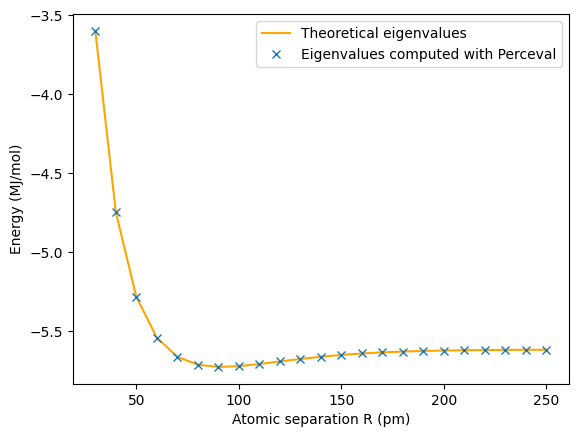

The minimum energy is E_g(0.9)=-5.72524139690732 MJ/mol and is attained for R_min =0.9 pm


In [5]:
plt.plot(100*np.array(radius1), np.array(E1_th)[range(5, 50, 2)],'orange')
plt.plot(100*np.array(radius1), E1,'x')
# plt.axis([50,250,-5.8,-5.5])
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])

plt.show()

min_value=min(E1)
min_index = E1.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')

## Streamline the minimization process

In [6]:
# Define a function that given a Hamiltonian, ansatz, minimization method etc, minizes the given the Hamiltonian

def minimize_hamiltonian(H, ansatz_params,  method, maxiter, init_param=[]):
    ansatz, List_Parameters = ansatz_params
    if len(init_param) == 0:
        init_param = [2*np.pi*np.random.random() for _ in List_Parameters]
    else:
        for i in range(len(init_param)):
            init_param[i] = VQE.get_parameters()[i]._value

    # Finding the ground state eigen value for each H(R)
    result = minimize(loss_function, init_param, args=(List_Parameters, ansatz, H), method=method, options={'maxiter': maxiter})
    # print(f'number of function evaluations: {result.nfev}')

    return result    

In [7]:
ansatz_params = ansatz()

H = get_qubit_hamiltonian(num_orbitals=1)

method = 'COBYLA'

maxiter = 90

minimize_hamiltonian(H, ansatz_params, method, maxiter)

/Users/farrokhlabib/Documents/github/QLASS/.venv/lib/python3.12/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.0810405775302445
       x: [ 6.066e+00  4.796e+00  5.199e+00  4.746e+00  4.108e+00
            4.661e+00  2.925e+00  1.726e+00]
    nfev: 90
   maxcv: 0.0

In [8]:
brute_force_minimize(H)

(-1.0814059945808578+0j)

In [9]:
H = get_qubit_hamiltonian(num_orbitals=5)
H_matrix = hamiltonian_matrix(H)

In [10]:
def sparsity(H_matrix):
    L = len(H_matrix)
    avg_num_nonzero = 0
    for i in range(L):
        num_nonzero_row = 0
        for j in range(L):
            if np.abs(H_matrix[i][j]) > 10**(-5):
                num_nonzero_row += 1
        avg_num_nonzero += num_nonzero_row/L
    
    return avg_num_nonzero

sparsity(H_matrix), len(H_matrix)

(10.9873046875, 1024)

In [11]:
brute_force_minimize(H)

(-1.1001883332810718+1.471786160371654e-31j)

In [12]:
eig_decomp_lanczos(H_matrix)

array([-1.10018833, -1.02329562, -0.97801784, -0.96167328, -0.94372494,
       -0.93038053, -0.90870367, -0.85031604, -0.83587262, -0.81887138,
       -0.77881463, -0.75876551, -0.73055248, -0.6722222 , -0.61852056,
       -0.57272977, -0.53549955, -0.48360033, -0.44414343, -0.38612875,
       -0.34037616, -0.26937547, -0.22104733, -0.15943397, -0.09073102,
       -0.02337679,  0.        ,  0.04291287,  0.12731783,  0.18479184,
        0.2612047 ,  0.32836088,  0.41567184,  0.48563118,  0.57209936,
        0.65009417,  0.72661778,  0.82543024,  0.95669417,  1.02420968,
        1.09674983,  1.1763061 ,  1.27416754,  1.37259556,  1.43933811,
        1.54188544,  1.62492725,  1.7281236 ,  1.82136062,  1.9299525 ,
        1.99688537,  2.07368558,  2.18474977,  2.25204994,  2.35511374,
        2.44152909,  2.58201551,  2.6360327 ,  2.68771719,  2.78565722,
        2.83532578,  2.96367143,  3.11115725,  3.14797779,  3.18920952,
        3.26105362,  3.33421622,  3.34989018,  3.4476333 ,  3.46

In [13]:
%%timeit
brute_force_minimize(H)

4.85 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
eig_decomp_lanczos(H_matrix)

376 ms ± 77.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
